# Covid19 no Brasil


A base de dados deste notebook foi obtida em: <a href='https://www.kaggle.com/unanimad/corona-virus-brazil'> Coronavirus - Brazil </a>.

A estratégia utilizada foi realizar previsões do número de novos casos para um dia a frente para cada um dos estados do Brasil. O conjunto de dados forneceu uma série temporal com registros por estado de coronavírus no Brasil. Desta forma, o problema foi classificado como aprendizado supervisionado.

Durante as análises, observou-se que a maior ocorrência de número de casos e mortes são de capitais como SP e RJ. Entretanto a taxa de letalidade foi maior em estados menores. A taxa de letalidade foi maior entre os meses de abril de 2020 á junho de 2020, pressupõe-se que isso seja devido a esse período compreender justamente o ínicio da pandemia no Brasil e por ainda não ter um tratamento pré-definido.

Para realizar as previsões dos números de casos do dia seguinte para cada um dos estados do Brasil foram adotadas as seguintes tarefas:

  * Descrição dos dados através de estatística descritiva, com objetivo de identificar distribuições, dados faltantes e tipo dos dados.
  * Engenharia de atributos (do inglês <i>Feature engineering</i>) para criação de atributos sazonais e com defasagens, além da criação da variavel alvo (número de casos (<b>new_cases</b>)). 
  * Análise exploratória, para tirar insights e entender os dados.
  * Clusterização, com o objetivo de identificar número de casos similares entre os estados. Para isso utilizou-se um agrupamento hierárquico com o cálculo de distância <i>Dynamic Time Warping</i> (DTW), sendo avaliados pelo índice de índice de Silhueta.
  * Preparação dos dados, onde foram realizadas transformações para deixar atributos em uma mesma escala, além de transformações de natureza para os atributos de natureza cíclica.
  * Seleção de caractéristicas através do algoritmo <i>Boruta</i>
  * Aplicabilidade de modelos de aprendizado de máquina. Os modelos foram avaliados através das métricas MAE e RMSE. Para avaliação utilizou-se os últimos 30 dias, e o restante para treinamento.
  * Ajuste de hiperparâmetros.
  

<b>Conclusões:</b>
 * O resultado do agrupamento não foi bom. Obteve-se 2 clusters, sendo que o primeiro contemplava 26 estados (99%) e o outro 1%.
 * O modelo LightGBM com objetivo = distribuição tweedie foi a que apresentou o melhor desempenho nas previsões.


<b> Propostas de melhorias: </b>
 * Aplicar outro algoritmo de agrupamento e outras métricas de avaliação de clusterização, como o dendrograma.
 * Utilizar novas variáveis, preferencialmente externas. Tais como, variáveis que possam indicar o surgimento de novas variantes e o número de vacinados.
 * Alterar a granularidade, realizar previsões semanais ou mensais ao invés de diárias.
 * Explorar o uso de Redes Neurais Artificiais Recorrentes.
 

<h1> Imports</h1>

In [390]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats 
from fastdtw import fastdtw
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from statsmodels.graphics.tsaplots import plot_pacf
from boruta import BorutaPy
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import datetime
import random
from IPython.display import HTML
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose

In [391]:
register_matplotlib_converters()

<h1>1.0 Funções</h1>

In [392]:
# Função de Cramer V
def cramer_v(var_x, var_y):
    
    confusion_matrix = pd.crosstab(var_x, var_y).values
       
    n = confusion_matrix.sum()    
    
    r, k = confusion_matrix.shape
    
    chi2 = stats.chi2_contingency(confusion_matrix)[0]

    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

In [393]:
def ml_metrics(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model': model_name, 'MAE': mae, 'RMSE': rmse}, index=[0])

<h1> 2.0 Carregando dados </h1>

In [394]:
df = pd.read_csv('brazil_covid19.csv')

In [395]:
df.head()

,date,region,state,cases,deaths
0,2020-02-25,Centro-Oeste,DF,0.0,0
1,2020-02-25,Centro-Oeste,GO,0.0,0
2,2020-02-25,Centro-Oeste,MS,0.0,0
3,2020-02-25,Centro-Oeste,MT,0.0,0
4,2020-02-25,Nordeste,AL,0.0,0


## 2.1 Dicionário dos dados

* <b>date</b>: representa a data de registro de casos e mortes pela Covid19.
* <b>region</b>: representa a região onde ocorreu o número de casos e mortes pela Covid19.
* <b>state</b>: representa os estados (UF) em que ocorreu o número de casos ...
* <b>cases</b>: número de casos de Covid19 acumulados.
* <b>deaths</b>: número de mortes pela Covid19.

<h2> 2.2 Verificando existência de NaN </h2>

In [396]:
df.isnull().sum()

date      0
region    0
state     0
cases     0
deaths    0
dtype: int64

<h2>2.3 Dimensão dos dados</h2>

In [397]:
df.shape

(12258, 5)

<h2> 2.4 Tipos de dados </h2>

In [398]:
df.dtypes

date       object
region     object
state      object
cases     float64
deaths      int64
dtype: object

<p> Verificando os tipos, observa-se que o atributo 'date' está como object. O mesmo será convertido para datetime </p>

In [399]:
df['date'] = pd.to_datetime( df['date'] )

<h2> 2.5 Estatística descritiva </h2>

<h3> 2.5.1 Atributos numéricos </h3>

In [400]:
numericos_atr = df.select_dtypes(include = ['int32', 'int64', 'float64'])
categoricos_atr = df.select_dtypes(exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'])
tempo_atr = df.select_dtypes(include=['datetime64[ns]'])

In [401]:
c1 = pd.DataFrame( numericos_atr.apply( np.mean ) ).T
c2 = pd.DataFrame( numericos_atr.apply( np.median ) ).T

d1 = pd.DataFrame( numericos_atr.apply( np.std ) ).T 
d2 = pd.DataFrame( numericos_atr.apply( min ) ).T 
d3 = pd.DataFrame( numericos_atr.apply( max ) ).T 
d4 = pd.DataFrame( numericos_atr.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( numericos_atr.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( numericos_atr.apply( lambda x: x.kurtosis() ) ).T 

m = pd.concat( [d2, d3, d4, c1, c2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,cases,0.0,3188105.0,3188105.0,208515.145293,106550.0,328136.315459,4.139996,24.312845
1,deaths,0.0,107614.0,107614.0,5701.935308,2627.0,10237.893279,4.665177,29.827160


* <b>Existem dias em que não foram registrados casos e nem mortes.</b>
* <b>Ambos atributos possuem uma distribuição assimétrica a direita.</b>
* <b>Ambos possuem uma alta dispersão em relação a média devido ao desvio padrão ser maior que a média.</b>
* <b>Ambos atributos possuem caudas pesadas e são classificadas como Leptocúrtica.</b>

<h3> 2.5.2 Atributos categóricos </h3>

In [402]:
categoricos_atr.apply(lambda x: x.unique().shape[0])

region     5
state     27
dtype: int64

#### Exsitem 5 diferentes regiões e registro de todos os estados do Brasil.

<h3> 2.5.3 Temporal </h3>

In [403]:
print( 'Data min: {}'.format( tempo_atr.min()[0] ) )
print( 'Data max: {}'.format( tempo_atr.max()[0] ) )

Data min: 2020-02-25 00:00:00
Data max: 2021-05-23 00:00:00


In [404]:
print('Qtd dias: ',tempo_atr.max()[0] - tempo_atr.min()[0])

Qtd dias:  453 days 00:00:00


#### O período do conjunto de dados abrange desde 25/02/2020 á 23/05/2021. Isso significa que existem registros da coronavíris desde o ínicio da pandemia no Brasil. Ao todo tem-se 453 dias.

In [405]:
dft=df.copy()

<h1> 3 Engenharia de atributos </h1>

In [406]:
def create_sazonality_atr(df_p):
    dft = df_p.copy()
    dft['month']     = df_p['date'].dt.month
    dft['year']      = df_p['date'].dt.year
    dft['week_day']  = df_p['date'].dt.weekday
    dft['year_week'] = df_p['date'].dt.weekofyear
    
    return dft

def create_others_atr(df_p,analysis=False):
    dfo = df_p.copy()        

    if analysis:
        dfo['letality_rate'] = dfo['deaths']/(dfo['cases']+1)
        
    dfo['nlag_1'] = dfo.groupby('state')['cases'].shift(1)   

    return dfo

def create_target(df_p):
    dfo = df_p.copy()
    def get_new_case(row):
        return row['cases']-row['nlag_1']
    dfo['new_cases'] = dfo.apply(lambda x: get_new_case(x),axis=1)
    dfo['new_cases'] = dfo['new_cases'].apply(lambda x: 0 if x < 0  else x )
    
    dfo = dfo.drop('nlag_1',axis=1)
    return dfo

def create_time_lagging_atr(df_p, use_state = True, modeling=False):  
    df2=df_p.copy()
    
    df2['moving_average_7'] = df2['new_cases'].rolling(window=7).mean()
    df2['moving_average_14'] = df2['new_cases'].rolling(window=14).mean()   
    df2['cases_lag_1'] = df2['cases'].shift(1)
    
    if use_state:
        qtd_month = df_p[['year','month','cases','state']].groupby(['year','month','state']).sum().reset_index()
        qtd_month['lag_cases_1_month'] = qtd_month['cases'].shift(1)
        qtd_month['lag_cases_2_month'] = qtd_month['cases'].shift(2)
        qtd_month['lag_cases_3_month'] = qtd_month['cases'].shift(3)
              
        df2 = pd.merge(df2,qtd_month.drop('cases',axis=1),how='left', on=['year','month','state']) 
        
    if modeling:
        for i in range(1,20):
            df2['new_cases_lag_{}'.format(i)] = df2['new_cases'].shift(i)
            
        
    
    return df2

<h1>4 Análise exploratória</h1>

In [407]:
df2 = df.copy()

<h2>4.1 Análise univariada</h2>

In [408]:
df_eda_c = df2.copy()

In [409]:
df_eda_c = create_sazonality_atr(df_eda_c)
df_eda_c = create_others_atr(df_eda_c,True)
df_eda_c = create_target(df_eda_c)

In [410]:
df_eda_c

,date,region,state,cases,deaths,month,year,week_day,year_week,letality_rate,new_cases
0,2020-02-25,Centro-Oeste,DF,0.0,0,2,2020,1,9,0.000000,NaN
1,2020-02-25,Centro-Oeste,GO,0.0,0,2,2020,1,9,0.000000,NaN
2,2020-02-25,Centro-Oeste,MS,0.0,0,2,2020,1,9,0.000000,NaN
3,2020-02-25,Centro-Oeste,MT,0.0,0,2,2020,1,9,0.000000,NaN
4,2020-02-25,Nordeste,AL,0.0,0,2,2020,1,9,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
12253,2021-05-23,Sudeste,RJ,840480.0,49515,5,2021,6,20,0.058913,857.0
12254,2021-05-23,Sudeste,SP,3188105.0,107614,5,2021,6,20,0.033755,7510.0
12255,2021-05-23,Sul,PR,1060683.0,25506,5,2021,6,20,0.024047,1180.0
12256,2021-05-23,Sul,RS,1059990.0,27419,5,2021,6,20,0.025867,922.0


<h3>4.1.1 Variável numérica</h3>

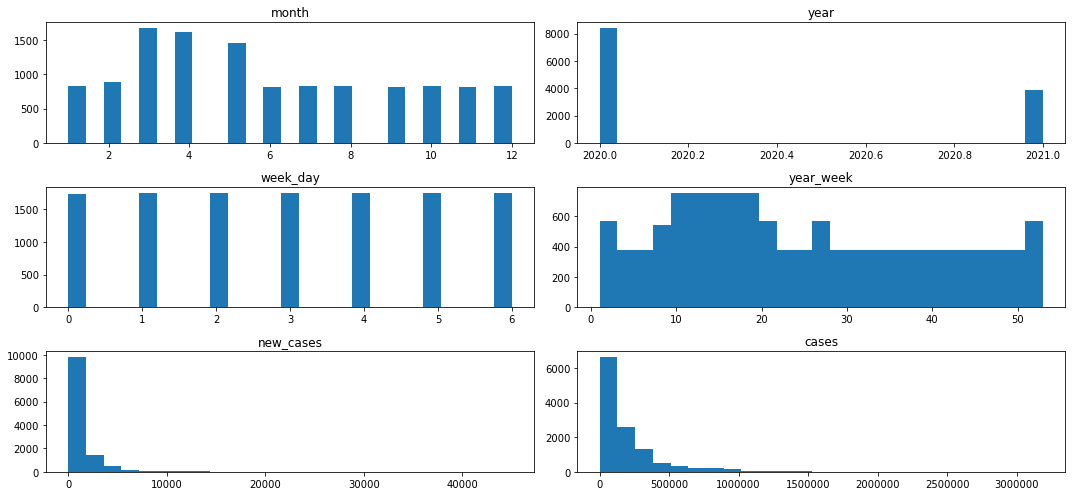

In [411]:
h = df_eda_c.copy()
histo = h.select_dtypes(include=['int64','int32','float'])
histo = histo[['month','year','week_day','year_week','new_cases','cases']]
fig, ax = plt.subplots(3,2,figsize=(15,7))
axs = ax.flatten()
for col, ax in zip(histo.columns, axs):
    df_eda_c[col].hist(ax=ax, grid=False,bins=25)          
    ax.set_title(col)
#fig.delaxes(axs[9])        
plt.tight_layout()

<h3>4.1.2 Variável alvo </h3>

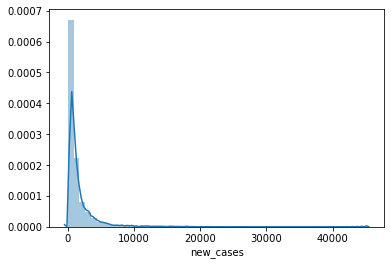

In [412]:
sns.distplot(df_eda_c['new_cases'].dropna());

#### A variável alvo possui uma alta frequência de zeros e é assimétrica.

<h3>4.1.3 Variável categórica</h3>

In [413]:
df_eda_c['region'].value_counts(normalize=True)*100

Nordeste        33.333333
Norte           25.925926
Centro-Oeste    14.814815
Sudeste         14.814815
Sul             11.111111
Name: region, dtype: float64

In [414]:
df_eda_c['state'].drop_duplicates()

0     DF
1     GO
2     MS
3     MT
4     AL
5     BA
6     CE
7     MA
8     PB
9     PE
10    PI
11    RN
12    SE
13    AC
14    AM
15    AP
16    PA
17    RO
18    RR
19    TO
20    ES
21    MG
22    RJ
23    SP
24    PR
25    RS
26    SC
Name: state, dtype: object

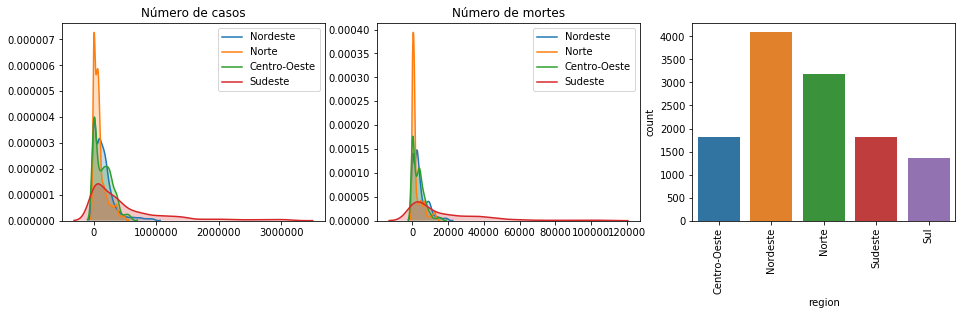

In [415]:
# Usa variável ax para um único eixo
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 8)

plt.subplot(2,3,1)
sns.kdeplot(df_eda_c[df_eda_c['region'] == 'Nordeste']['cases'], label='Nordeste', shade=True)
sns.kdeplot(df_eda_c[df_eda_c['region'] == 'Norte']['cases'], label='Norte', shade=True)
sns.kdeplot(df_eda_c[df_eda_c['region'] == 'Centro-Oeste']['cases'], label='Centro-Oeste', shade=True)
sns.kdeplot(df_eda_c[df_eda_c['region'] == 'Sudeste']['cases'], label='Sudeste', shade=True)
plt.title('Número de casos');

plt.subplot(2,3,2)
sns.kdeplot(df_eda_c[df_eda_c['region'] == 'Nordeste']['deaths'], label='Nordeste', shade=True)
sns.kdeplot(df_eda_c[df_eda_c['region'] == 'Norte']['deaths'], label='Norte', shade=True)
sns.kdeplot(df_eda_c[df_eda_c['region'] == 'Centro-Oeste']['deaths'], label='Centro-Oeste', shade=True)
sns.kdeplot(df_eda_c[df_eda_c['region'] == 'Sudeste']['deaths'], label='Sudeste', shade=True)
plt.title('Número de mortes');

plt.subplot(2,3,3)
sns.countplot(df_eda_c.region)
plt.xticks(rotation=90)
plt.show();

#### 1. O conjunto de dados possui mais registros da região Nordeste.
#### 2. Sudeste é o que menos obteve ocorrência em casos e mortes.

<h2>4.2 Análise bivariada </h2>

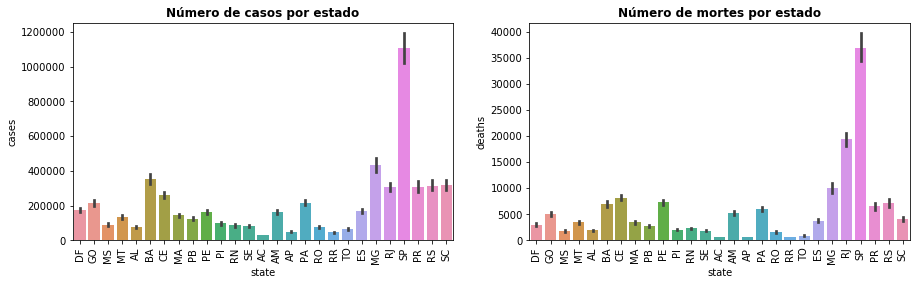

In [416]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.barplot(x='state',y='cases',data=df_eda_c)
plt.xticks(rotation=90)
plt.title('Número de casos por estado',weight='bold')

plt.subplot(1,2,2)
sns.barplot(x='state',y='deaths',data=df_eda_c)
plt.xticks(rotation=90)
plt.title('Número de mortes por estado',weight='bold')
plt.show();

#### <p>Observou-se uma alta variabilidade no número de casos e de mortes por estado. Isso já era esperado, uma vez que existem estados maiores que outros. Nota-se que o estado de SP lidera com o maior número de mortes e casos, seguido pelo RJ </p>

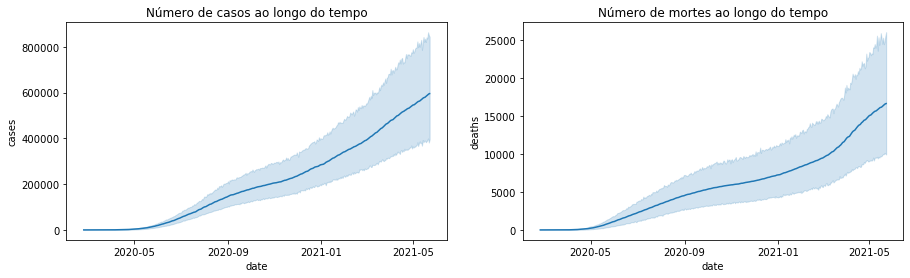

In [417]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)

sns.lineplot(x='date',y='cases',data=df_eda_c)
plt.title('Número de casos ao longo do tempo')
fmt_half_month = mdates.MonthLocator(interval=4)
plt.gca().xaxis.set_major_locator(fmt_half_month)

plt.subplot(1,2,2)
sns.lineplot(x='date',y='deaths',data=df_eda_c)
plt.title('Número de mortes ao longo do tempo')
fmt_half_year = mdates.MonthLocator(interval=4)
plt.gca().xaxis.set_major_locator(fmt_half_year)
plt.show();

#### A tendência de casos e mortes são sempre crescentes.

<b><center>Taxa de letalidade da covid19 no Brasil<b></center>

In [418]:
letality = np.sum(df_eda_c['deaths'])/np.sum(df_eda_c['cases'])
print('taxa de letalidade até {} é de {:.3f} %'.format(df_eda_c['date'].max(),letality*100))

taxa de letalidade até 2021-05-23 00:00:00 é de 2.735 %


<center><b>Taxa de letalidade ao longo do tempo no Brasil</b></center>

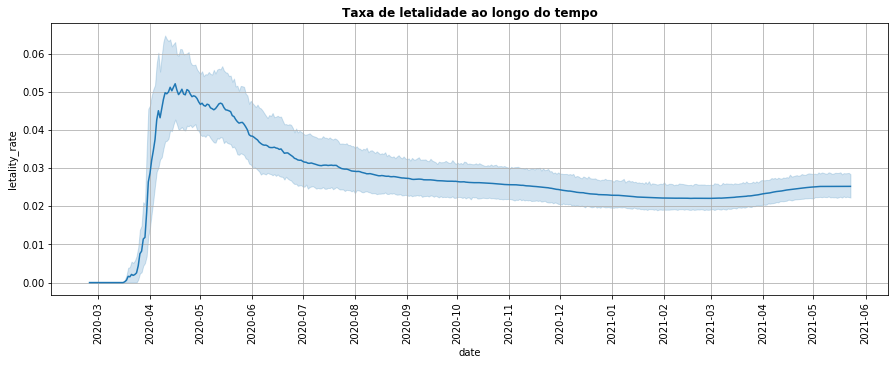

In [419]:
plt.figure(figsize=(15,5))
sns.lineplot(x='date',y='letality_rate',data=df_eda_c)
fmt_half_month = mdates.MonthLocator(interval=1)
plt.gca().xaxis.set_major_locator(fmt_half_month)
plt.xticks(rotation=90)
plt.grid(True)
plt.title('Taxa de letalidade ao longo do tempo',weight='bold')
plt.show();

#### Observa-se que a maior taxa de letalidade ocorreu entre abril/2020 á junho/2020, após esse período houve uma queda. Esse pico pode ser devido ao surgimento de novas variantes da Sars-cov2.

<center><b>Taxa de letalidade por estado</b><center>

In [420]:
df_eda_c

,date,region,state,cases,deaths,month,year,week_day,year_week,letality_rate,new_cases
0,2020-02-25,Centro-Oeste,DF,0.0,0,2,2020,1,9,0.000000,NaN
1,2020-02-25,Centro-Oeste,GO,0.0,0,2,2020,1,9,0.000000,NaN
2,2020-02-25,Centro-Oeste,MS,0.0,0,2,2020,1,9,0.000000,NaN
3,2020-02-25,Centro-Oeste,MT,0.0,0,2,2020,1,9,0.000000,NaN
4,2020-02-25,Nordeste,AL,0.0,0,2,2020,1,9,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
12253,2021-05-23,Sudeste,RJ,840480.0,49515,5,2021,6,20,0.058913,857.0
12254,2021-05-23,Sudeste,SP,3188105.0,107614,5,2021,6,20,0.033755,7510.0
12255,2021-05-23,Sul,PR,1060683.0,25506,5,2021,6,20,0.024047,1180.0
12256,2021-05-23,Sul,RS,1059990.0,27419,5,2021,6,20,0.025867,922.0


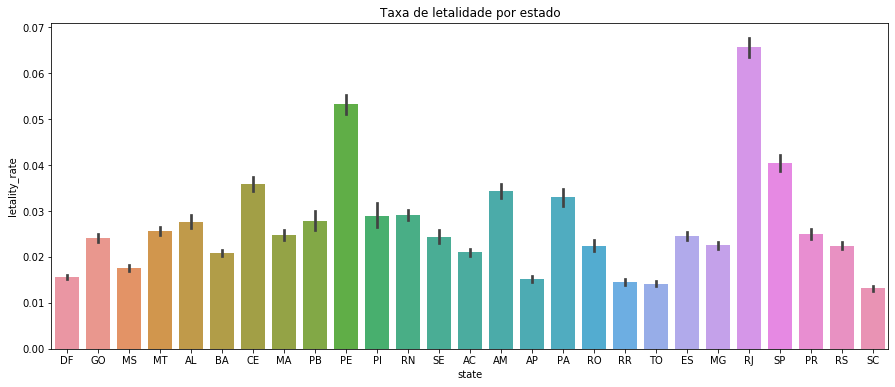

In [421]:
plt.figure(figsize=(15,6))
sns.barplot(data=df_eda_c,x='state',y='letality_rate')
plt.title('Taxa de letalidade por estado')
plt.show();

#### A maior taxa de letalidade ocorreu em RJ, seguido por PE

<center><b>Casos por mês, ano, dia da semana e semana do ano</b></center>

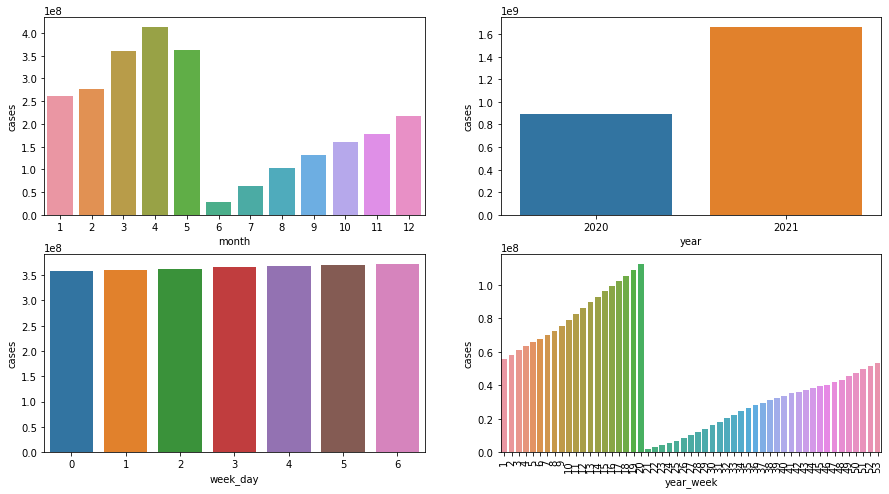

In [422]:
plt.figure(figsize=(15,8))

plt.subplot( 2, 2, 1 )
aux1 = df_eda_c[['month', 'cases']].groupby( 'month' ).sum().reset_index()
sns.barplot( x='month', y='cases', data=aux1 );

plt.subplot( 2, 2, 2 )
aux1 = df_eda_c[['year', 'cases']].groupby( 'year' ).sum().reset_index()
sns.barplot( x='year', y='cases', data=aux1 );

plt.subplot( 2, 2, 3 )
aux1 = df_eda_c[['week_day', 'cases']].groupby( 'week_day' ).sum().reset_index()
sns.barplot( x='week_day', y='cases', data=aux1 );

plt.subplot( 2, 2, 4 )
aux2 = df_eda_c[['year_week', 'cases']].groupby( 'year_week' ).sum().reset_index()
sns.barplot( x='year_week', y='cases', data=aux2 );
plt.xticks( rotation=90 );

#### * O maior número de casos ocorreu no mês de abril. 
#### * Houve mais casos no ano de 2021 do que em 2020. O que chama atenção é que os registros de 2020 contemplam praticamente o ano todo, já o de 2021 os dados compreendem de jan a maio. 
#### * Os casos por dia da semana seguem uniformemente
#### * Um maior número de casos é observado nas 20 primeiras semanas do ano, devido apenas ao ano de 2020 ter registros  dos meses de junho adiante. Da mesma forma para os meses a partir de junho.

<center><b>Mortes por mês, ano, dia da semana e semana do ano</b></center>

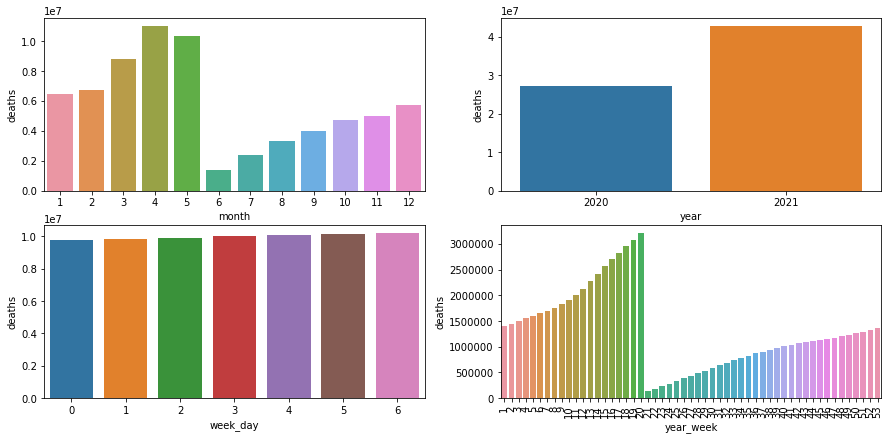

In [423]:
plt.figure(figsize=(15,7))

plt.subplot( 2, 2, 1 )
aux1 = df_eda_c[['month', 'deaths']].groupby( 'month' ).sum().reset_index()
sns.barplot( x='month', y='deaths', data=aux1 );

plt.subplot( 2, 2, 2 )
aux1 = df_eda_c[['year', 'deaths']].groupby( 'year' ).sum().reset_index()
sns.barplot( x='year', y='deaths', data=aux1 );

plt.subplot( 2, 2, 3 )
aux1 = df_eda_c[['week_day', 'deaths']].groupby( 'week_day' ).sum().reset_index()
sns.barplot( x='week_day', y='deaths', data=aux1 );

plt.subplot( 2, 2, 4 )
aux2 = df_eda_c[['year_week', 'deaths']].groupby( 'year_week' ).sum().reset_index()
sns.barplot( x='year_week', y='deaths', data=aux2 );
plt.xticks( rotation=90 );

#### Mesmas conclusões que do gráfico anterior.

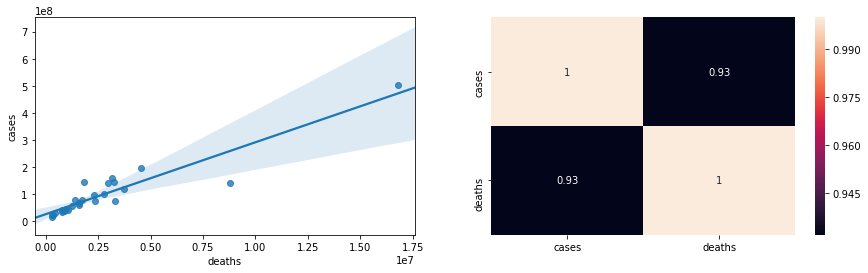

In [424]:
plt.figure(figsize=(15,4))
aux = df_eda_c[['cases','new_cases','deaths','state']].groupby('state').sum().reset_index()
plt.subplot(1, 2, 1)
sns.regplot(data=aux,x='deaths',y='cases')

plt.subplot(1,2,2)
sns.heatmap(aux[['cases','deaths']].corr(),annot=True);

#### * Quanto maior o número de casos, mais mortes ocorrem. Correlação positiva e muito forte.

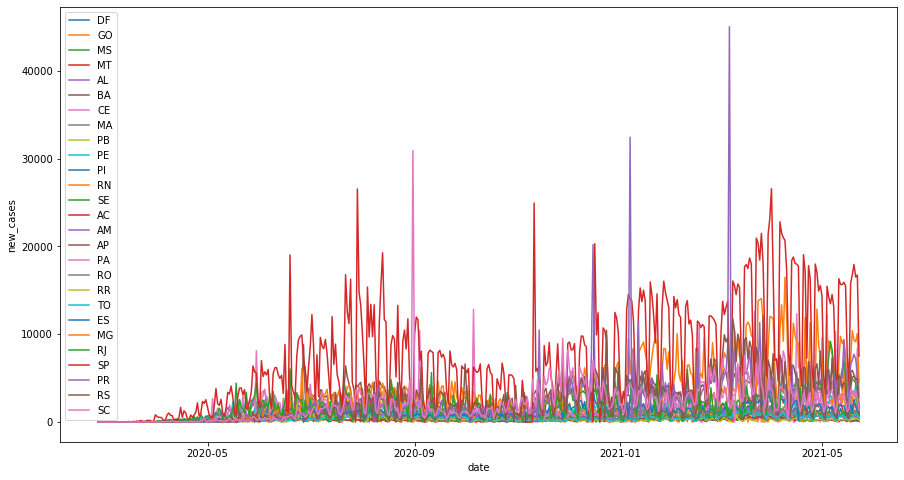

In [425]:
plt.figure(figsize=(15,8))
list_uf = df_eda_c['state'].drop_duplicates().tolist()

for uf in list_uf:
    p = df_eda_c[df_eda_c['state']==uf]
    sns.lineplot(x=p.date,y=p.new_cases,label=uf)
    fmt_half_month = mdates.MonthLocator(interval=4)
    plt.gca().xaxis.set_major_locator(fmt_half_month)

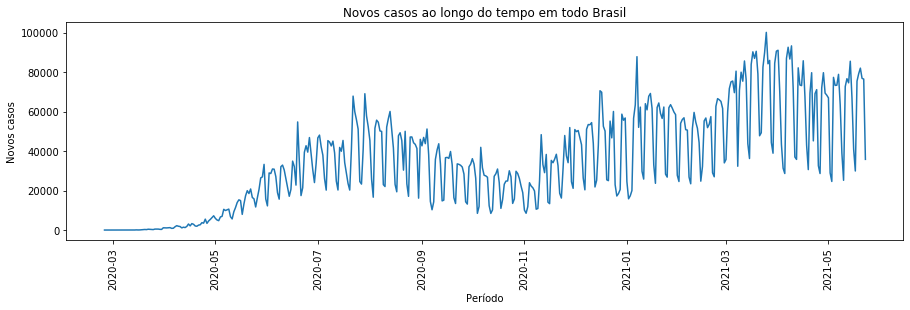

In [426]:
plt.figure(figsize=(15,4))
auxplot = df_eda_c[['date','new_cases']].groupby('date').sum().reset_index()
sns.lineplot(auxplot.date,auxplot.new_cases)
plt.xticks(rotation=90)
plt.xlabel('Período')
plt.ylabel('Novos casos')
plt.title('Novos casos ao longo do tempo em todo Brasil')
plt.show();

* Observa-se que existem alguns picos no surgimento de novos casos.

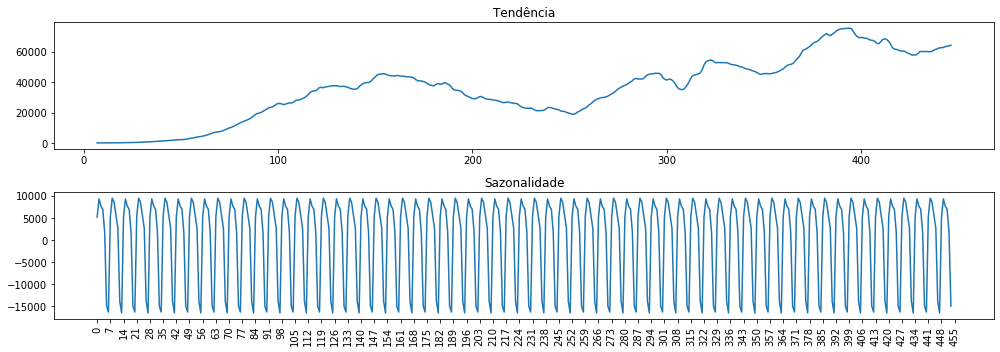

In [427]:
plt.figure(figsize=(14,5))
decompose = seasonal_decompose(auxplot.new_cases,freq=14)

plt.subplot(2,1,1)
plt.plot(decompose.trend)
plt.title('Tendência')

plt.subplot(2,1,2)
plt.plot(decompose.seasonal)
plt.xticks(range(0,457,7),rotation=90)
plt.title('Sazonalidade')

plt.tight_layout()

#### Observa-se que existem picos a cada sete dias no número de casos, além de possuir uma tendência crescente ao longo do tempo.

<h3>4.2.1 Atributos categóricos </h3>

Para calcular a correlação entre os atributos categóricos, foi utilizado medida de associação. Sendo está o V de Cramer.
Os valores possíves para o V de Cramer são entre 0 e 1.

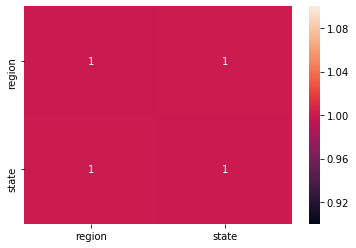

In [428]:
atr1 = cramer_v(df_eda_c['region'],df_eda_c['state'])
atr2 = cramer_v(df_eda_c['region'],df_eda_c['region'])

atr3 = cramer_v(df_eda_c['state'],df_eda_c['region'])
atr4 = cramer_v(df_eda_c['state'],df_eda_c['state'])

dc = pd.DataFrame({'region': [atr1,atr2],
                  'state': [atr3,atr4]})

dc = dc.set_index(dc.columns)

sns.heatmap(dc.corr(),annot=True)

<h1> 5 Similaridades de casos por estado </h1>

In [429]:
df_cluster = df_eda_c.copy()

In [430]:
df_cluster = create_others_atr(df_cluster)
df_cluster = create_target(df_cluster).dropna()

In [431]:
le = LabelEncoder()
df_cluster['state_number'] =  le.fit_transform(df_cluster[['state']].values.ravel())

In [432]:
list_state = df_cluster['state_number'].drop_duplicates().tolist()

In [433]:
np.max(list_state)

26

In [434]:
dimension_matrix = df_cluster['state_number'].drop_duplicates().shape[0]
distance_m = np.zeros((dimension_matrix, dimension_matrix))

for i in list_state:
    p1 = df_cluster[df_cluster['state_number'] == i]['new_cases'].values
    for j in list_state:
        p2 = df_cluster[df_cluster['state_number'] == j]['new_cases'].values               
        distance, path = fastdtw( p1, p2 )        
        distance_m[i][j] = distance

In [435]:
max_clusters = 15
clusters = np.arange( 2, max_clusters+1 )
silhoute = []


for i in clusters:
    print('cluster: ',i)
    model = AgglomerativeClustering( affinity='precomputed',  n_clusters=i,  linkage='complete' ).fit(distance_m)
    ss = silhouette_score( distance_m, model.fit_predict( distance_m ) )
    silhoute.append(ss)

cluster:  2
cluster:  3
cluster:  4
cluster:  5
cluster:  6
cluster:  7
cluster:  8
cluster:  9
cluster:  10
cluster:  11
cluster:  12
cluster:  13
cluster:  14
cluster:  15


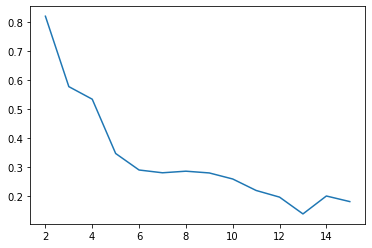

In [436]:
sns.lineplot(clusters, silhoute)

#### de acordo com o resultado do indice de silhoute, 2 clusters é o melhor número

In [437]:
mdl = AgglomerativeClustering(affinity='precomputed',n_clusters=2,linkage='complete').fit(distance_m)
clusters = mdl.labels_

states = df_cluster['state'].drop_duplicates().tolist()
cluster_the_for = dict(zip(states, clusters))

In [438]:
df_cluster['clusters'] = df_cluster['state'].copy()
df_cluster['clusters'] = df_cluster['clusters'].map(cluster_the_for)
df_cluster[['state', 'clusters']].drop_duplicates().groupby('clusters').count().reset_index()

,clusters,state
0,0,26
1,1,1


In [439]:
df_cluster[df_cluster.clusters==1]['state'].unique()

array(['RS'], dtype=object)

#### apenas o estado do SC teve diferença no número de novos casos em relação aos demais

<h1>6 Preparação dos dados</h1>

#### Remoção do atributo 'deaths' porque não temos o número de mortes no momento da previsão.

In [441]:
df.drop(['deaths'],axis=1,inplace=True)

In [442]:
df_covid1 = df.copy()

In [443]:
df_prep_covid1 = df_covid1.copy()

In [444]:
df_prep_covid1 = create_others_atr(df_prep_covid1)
df_prep_covid1 = create_target(df_prep_covid1)
df_prep_covid1 = create_sazonality_atr(df_prep_covid1)
df_prep_covid1 = create_time_lagging_atr(df_prep_covid1,True,True)

In [445]:
df_prep_covid1[df_prep_covid1['state']=='MG'].tail()

,date,region,state,cases,new_cases,month,year,week_day,year_week,moving_average_7,...,new_cases_lag_10,new_cases_lag_11,new_cases_lag_12,new_cases_lag_13,new_cases_lag_14,new_cases_lag_15,new_cases_lag_16,new_cases_lag_17,new_cases_lag_18,new_cases_lag_19
12144,2021-05-19,Sudeste,MG,1483200.0,10399.0,5,2021,2,20,2162.142857,...,1173.0,1753.0,3440.0,830.0,1186.0,3214.0,5111.0,507.0,1932.0,1896.0
12171,2021-05-20,Sudeste,MG,1492530.0,9330.0,5,2021,3,20,2277.428571,...,1378.0,1215.0,3188.0,892.0,1055.0,3322.0,5182.0,963.0,2084.0,1762.0
12198,2021-05-21,Sudeste,MG,1501670.0,9140.0,5,2021,4,20,2068.000000,...,1298.0,1224.0,3969.0,1156.0,1109.0,2732.0,4801.0,391.0,1705.0,1942.0
12225,2021-05-22,Sudeste,MG,1511756.0,10086.0,5,2021,5,20,2121.428571,...,1362.0,1127.0,3589.0,1415.0,728.0,8385.0,4461.0,586.0,1274.0,1954.0
12252,2021-05-23,Sudeste,MG,1516282.0,4526.0,5,2021,6,20,971.571429,...,283.0,838.0,2089.0,1249.0,159.0,3239.0,2875.0,896.0,656.0,1662.0


In [446]:
df_prep_covid1.tail()

,date,region,state,cases,new_cases,month,year,week_day,year_week,moving_average_7,...,new_cases_lag_10,new_cases_lag_11,new_cases_lag_12,new_cases_lag_13,new_cases_lag_14,new_cases_lag_15,new_cases_lag_16,new_cases_lag_17,new_cases_lag_18,new_cases_lag_19
12253,2021-05-23,Sudeste,RJ,840480.0,857.0,5,2021,6,20,1040.571429,...,1468.0,283.0,838.0,2089.0,1249.0,159.0,3239.0,2875.0,896.0,656.0
12254,2021-05-23,Sudeste,SP,3188105.0,7510.0,5,2021,6,20,2088.571429,...,65.0,1468.0,283.0,838.0,2089.0,1249.0,159.0,3239.0,2875.0,896.0
12255,2021-05-23,Sul,PR,1060683.0,1180.0,5,2021,6,20,2218.142857,...,337.0,65.0,1468.0,283.0,838.0,2089.0,1249.0,159.0,3239.0,2875.0
12256,2021-05-23,Sul,RS,1059990.0,922.0,5,2021,6,20,2318.142857,...,374.0,337.0,65.0,1468.0,283.0,838.0,2089.0,1249.0,159.0,3239.0
12257,2021-05-23,Sul,SC,947810.0,1353.0,5,2021,6,20,2458.857143,...,174.0,374.0,337.0,65.0,1468.0,283.0,838.0,2089.0,1249.0,159.0


## 6.1 Scalling

In [447]:
df_prep_covid1.head()

,date,region,state,cases,new_cases,month,year,week_day,year_week,moving_average_7,...,new_cases_lag_10,new_cases_lag_11,new_cases_lag_12,new_cases_lag_13,new_cases_lag_14,new_cases_lag_15,new_cases_lag_16,new_cases_lag_17,new_cases_lag_18,new_cases_lag_19
0,2020-02-25,Centro-Oeste,DF,0.0,NaN,2,2020,1,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25,Centro-Oeste,GO,0.0,NaN,2,2020,1,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-25,Centro-Oeste,MS,0.0,NaN,2,2020,1,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-25,Centro-Oeste,MT,0.0,NaN,2,2020,1,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-25,Nordeste,AL,0.0,NaN,2,2020,1,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


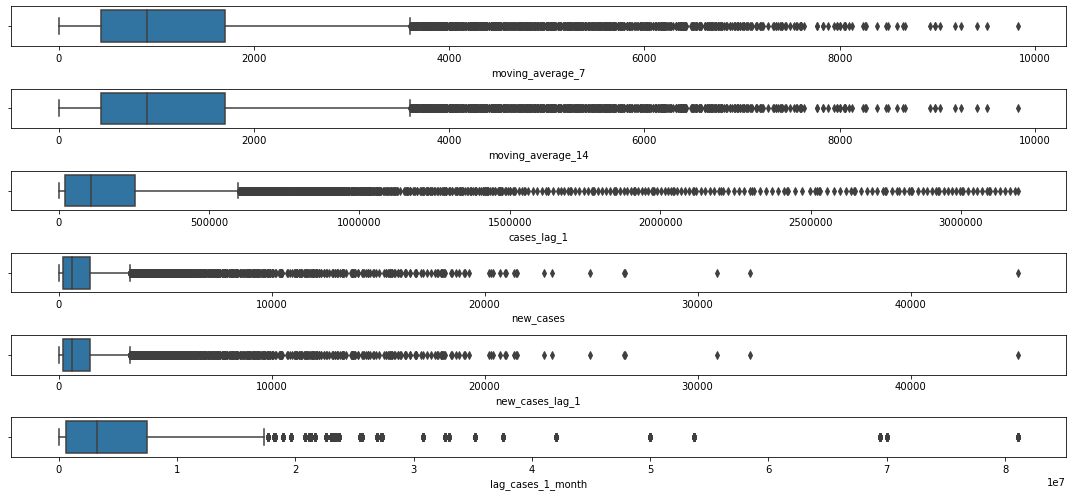

In [448]:

plt.figure(figsize=(15,7))
plt.subplot(6, 1, 1)
sns.boxplot(x='moving_average_7', data=df_prep_covid1)

plt.subplot(6, 1, 2)
sns.boxplot(x='moving_average_14', data=df_prep_covid1)

plt.subplot(6, 1, 3)
sns.boxplot(x='cases_lag_1', data=df_prep_covid1)

plt.subplot(6, 1, 4)
sns.boxplot(x='new_cases', data=df_prep_covid1);

plt.subplot(6, 1, 5)
sns.boxplot(x='new_cases_lag_1', data=df_prep_covid1);

plt.subplot(6, 1, 6)
sns.boxplot(x='lag_cases_1_month', data=df_prep_covid1);

plt.tight_layout()

In [449]:

rs = RobustScaler()
df_prep_covid1['moving_average_7']  = rs.fit_transform(df_prep_covid1[['moving_average_7']])
rs = RobustScaler()
df_prep_covid1['moving_average_14'] = rs.fit_transform(df_prep_covid1[['moving_average_14']])
rs = RobustScaler()
df_prep_covid1['cases_lag_1']       = rs.fit_transform(df_prep_covid1[['cases_lag_1']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_1'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_1']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_2'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_2']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_3'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_3']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_4'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_4']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_5'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_5']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_6'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_6']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_7'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_7']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_8'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_8']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_9'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_9']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_10'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_10']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_11'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_11']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_12'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_12']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_13'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_13']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_14'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_14']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_15'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_15']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_16'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_16']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_17'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_17']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_18'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_18']])
rs = RobustScaler()
df_prep_covid1['new_cases_lag_19'] = rs.fit_transform(df_prep_covid1[['new_cases_lag_19']])
rs = RobustScaler()
df_prep_covid1['lag_cases_1_month'] = rs.fit_transform(df_prep_covid1[['lag_cases_1_month']])
rs = RobustScaler()
df_prep_covid1['lag_cases_2_month'] = rs.fit_transform(df_prep_covid1[['lag_cases_2_month']])
rs = RobustScaler()
df_prep_covid1['lag_cases_3_month'] = rs.fit_transform(df_prep_covid1[['lag_cases_3_month']])

mms = MinMaxScaler()
df_prep_covid1['year'] = mms.fit_transform(df_prep_covid1[['year']])

## 6.2 transformação de natureza

In [57]:
df_prep_covid1['month_sin'] = df_prep_covid1['month'].apply(lambda x: np.sin(x * (2. * np.pi/31)))
df_prep_covid1['month_cos'] = df_prep_covid1['month'].apply(lambda x: np.cos(x * (2. * np.pi/31)))
df_prep_covid1['week_day_sin'] = df_prep_covid1['week_day'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df_prep_covid1['week_day_cos'] = df_prep_covid1['week_day'].apply(lambda x: np.cos(x * (2. * np.pi/7)))
df_prep_covid1['year_week_sin'] = df_prep_covid1['year_week'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df_prep_covid1['year_week_cos'] = df_prep_covid1['year_week'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

## 6.3 Transformação da variável alvo

In [58]:
df_prep_covid1['new_cases'] = np.log1p(df_prep_covid1.new_cases)

## 6.4 Transformação das variáveis categóricas

In [60]:
df_prep_covid1 = pd.get_dummies(data=df_prep_covid1,columns=['region','state'])

In [61]:
df_prep_covid1.head()

,date,cases,new_cases,month,year,week_day,year_week,moving_average_7,moving_average_14,cases_lag_1,...,state_PR,state_RJ,state_RN,state_RO,state_RR,state_RS,state_SC,state_SE,state_SP,state_TO
0,2020-02-25,0.0,NaN,2,0.0,1,9,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2020-02-25,0.0,NaN,2,0.0,1,9,NaN,NaN,-0.461799,...,0,0,0,0,0,0,0,0,0,0
2,2020-02-25,0.0,NaN,2,0.0,1,9,NaN,NaN,-0.461799,...,0,0,0,0,0,0,0,0,0,0
3,2020-02-25,0.0,NaN,2,0.0,1,9,NaN,NaN,-0.461799,...,0,0,0,0,0,0,0,0,0,0
4,2020-02-25,0.0,NaN,2,0.0,1,9,NaN,NaN,-0.461799,...,0,0,0,0,0,0,0,0,0,0


<h1>7 Feature Selection</h1>

In [62]:
cols_drop = ['month', 'week_day', 'year_week']
df_prep_covid1 = df_prep_covid1.drop(cols_drop, axis=1)

In [63]:
df_prep_covid1.dropna(inplace=True)

In [64]:
rf = RandomForestRegressor(n_jobs=-1)
boruta = BorutaPy(rf, n_estimators=500,max_iter=60, verbose=2).fit(df_prep_covid1.drop(['date','cases','new_cases'],axis=1).values, df_prep_covid1.new_cases)

Iteration: 	1 / 60
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	2 / 60
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	3 / 60
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	4 / 60
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	5 / 60
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	6 / 60
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	7 / 60
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	8 / 60
Confirmed: 	27
Tentative: 	7
Rejected: 	30
Iteration: 	9 / 60
Confirmed: 	27
Tentative: 	7
Rejected: 	30
Iteration: 	10 / 60
Confirmed: 	27
Tentative: 	7
Rejected: 	30
Iteration: 	11 / 60
Confirmed: 	27
Tentative: 	7
Rejected: 	30
Iteration: 	12 / 60
Confirmed: 	29
Tentative: 	5
Rejected: 	30
Iteration: 	13 / 60
Confirmed: 	29
Tentative: 	5
Rejected: 	30
Iteration: 	14 / 60
Confirmed: 	29
Tentative: 	4
Rejected: 	31
Iteration: 	15 / 60
Confirmed: 	29
Tentative: 	4
Rejected: 	31
Iteration: 	16 / 60
Confirmed: 	30
Tentative: 	3
Rejected: 	31
Iteratio

In [75]:
col_sels = boruta.support_.tolist()

df_fs = df_prep_covid1.drop(['date','new_cases','cases'],axis=1)
cols_selected = df_fs.iloc[:, col_sels].columns.to_list()
cols_not_selected = list(np.setdiff1d(df_fs.columns, col_sels))

In [76]:
cols_selected

['moving_average_7',
 'moving_average_14',
 'cases_lag_1',
 'lag_cases_1_month',
 'lag_cases_2_month',
 'lag_cases_3_month',
 'new_cases_lag_1',
 'new_cases_lag_2',
 'new_cases_lag_3',
 'new_cases_lag_4',
 'new_cases_lag_5',
 'new_cases_lag_6',
 'new_cases_lag_7',
 'new_cases_lag_8',
 'new_cases_lag_9',
 'new_cases_lag_10',
 'new_cases_lag_11',
 'new_cases_lag_12',
 'new_cases_lag_13',
 'new_cases_lag_14',
 'new_cases_lag_15',
 'new_cases_lag_16',
 'new_cases_lag_17',
 'new_cases_lag_18',
 'new_cases_lag_19',
 'year_week_cos',
 'region_Sudeste',
 'region_Sul',
 'state_AM',
 'state_BA',
 'state_CE',
 'state_PA']

#### adicionando demais atributos manualmente

In [78]:
cols_selected.extend(['date','new_cases','year_week_sin'])

In [79]:
cols_selected

['moving_average_7',
 'moving_average_14',
 'cases_lag_1',
 'lag_cases_1_month',
 'lag_cases_2_month',
 'lag_cases_3_month',
 'new_cases_lag_1',
 'new_cases_lag_2',
 'new_cases_lag_3',
 'new_cases_lag_4',
 'new_cases_lag_5',
 'new_cases_lag_6',
 'new_cases_lag_7',
 'new_cases_lag_8',
 'new_cases_lag_9',
 'new_cases_lag_10',
 'new_cases_lag_11',
 'new_cases_lag_12',
 'new_cases_lag_13',
 'new_cases_lag_14',
 'new_cases_lag_15',
 'new_cases_lag_16',
 'new_cases_lag_17',
 'new_cases_lag_18',
 'new_cases_lag_19',
 'year_week_cos',
 'region_Sudeste',
 'region_Sul',
 'state_AM',
 'state_BA',
 'state_CE',
 'state_PA',
 'date',
 'new_cases',
 'year_week_sin']

In [69]:
rf = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
mdl = rf.fit(df_prep_covid1.drop(['date','new_cases','cases'],axis=1),
             np.log1p(df_prep_covid1.new_cases))

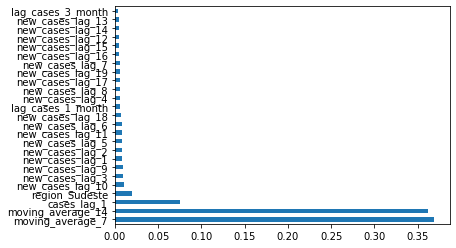

In [70]:
feat_importances = pd.Series(mdl.feature_importances_, index=df_prep_covid1.drop(['date','new_cases','cases'],axis=1).columns)
feat_importances.nlargest(25).plot(kind='barh')

<h1>8 Modelos de aprendizado de máquina</h1>

Os dados vão ser dividos em treino / teste.
Sendo que para teste será utilizado os últimos 30 dias do conjunto de dados e para treino todo restante anterior a ele.

In [80]:
def transform_cyclic(p_df):
    df=p_df.copy()
    df['month_sin'] = df['month'].apply(lambda x: np.sin(x * (2. * np.pi/31)))
    df['month_cos'] = df['month'].apply(lambda x: np.cos(x * (2. * np.pi/31)))
    df['week_day_sin'] = df['week_day'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
    df['week_day_cos'] = df['week_day'].apply(lambda x: np.cos(x * (2. * np.pi/7)))
    df['year_week_sin'] = df['year_week'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
    df['year_week_cos'] = df['year_week'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
    
    return df

In [81]:
df_models = df.copy()
df_models = create_others_atr(df_models)
df_models = create_target(df_models)
df_models = create_sazonality_atr(df_models)
df_models = create_time_lagging_atr(df_models,True,True)
df_models = transform_cyclic(df_models)
df_models = pd.get_dummies(df_models,columns=['region','state'])
df_models = df_models[cols_selected]

In [82]:
df_models.head()

,moving_average_7,moving_average_14,cases_lag_1,lag_cases_1_month,lag_cases_2_month,lag_cases_3_month,new_cases_lag_1,new_cases_lag_2,new_cases_lag_3,new_cases_lag_4,...,year_week_cos,region_Sudeste,region_Sul,state_AM,state_BA,state_CE,state_PA,date,new_cases,year_week_sin
0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.464723,0,0,0,0,0,0,2020-02-25,NaN,0.885456
1,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.464723,0,0,0,0,0,0,2020-02-25,NaN,0.885456
2,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.464723,0,0,0,0,0,0,2020-02-25,NaN,0.885456
3,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.464723,0,0,0,0,0,0,2020-02-25,NaN,0.885456
4,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.464723,0,0,0,0,0,0,2020-02-25,NaN,0.885456


In [83]:
date_start_validation_set = df_models['date'].max() - datetime.timedelta(days=30)

df_train = df_models[df_models['date'] <= date_start_validation_set].copy()
df_test  = df_models[df_models['date'] > date_start_validation_set].copy()

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [84]:
df_train.shape

(11393, 35)

In [85]:
df_test.shape

(810, 35)

## 8.1 Baseline

In [86]:
df_train.head()

,moving_average_7,moving_average_14,cases_lag_1,lag_cases_1_month,lag_cases_2_month,lag_cases_3_month,new_cases_lag_1,new_cases_lag_2,new_cases_lag_3,new_cases_lag_4,...,year_week_cos,region_Sudeste,region_Sul,state_AM,state_BA,state_CE,state_PA,date,new_cases,year_week_sin
46,0.000000,0.000000,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.464723,0,0,0,0,0,0,2020-02-26,0.0,0.885456
47,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.464723,1,0,0,0,0,0,2020-02-26,0.0,0.885456
48,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.464723,1,0,0,0,0,0,2020-02-26,0.0,0.885456
49,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.464723,1,0,0,0,0,0,2020-02-26,0.0,0.885456
50,0.142857,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.464723,1,0,0,0,0,0,2020-02-26,1.0,0.885456


In [90]:
mms_new_cases = MinMaxScaler()
rs_mm7 = RobustScaler()
rs_mm14 = RobustScaler()
mms_cases_lag = MinMaxScaler()
rs_new_cases1 = RobustScaler()
rs_new_cases2 = RobustScaler()
rs_new_cases3 = RobustScaler()
rs_new_cases4 = RobustScaler()
rs_new_cases5 = RobustScaler()
rs_new_cases6 = RobustScaler()
rs_new_cases7 = RobustScaler()
rs_new_cases8 = RobustScaler()
rs_new_cases9 = RobustScaler()
rs_new_cases10 = RobustScaler()
rs_new_cases11 = RobustScaler()
rs_new_cases12 = RobustScaler()
rs_new_cases13 = RobustScaler()
rs_new_cases14 = RobustScaler()
rs_new_cases15 = RobustScaler()
rs_new_cases16 = RobustScaler()
rs_new_cases17 = RobustScaler()
rs_new_cases18 = RobustScaler()
rs_new_cases19 = RobustScaler()
rs_qtdmonth_cases_1 = RobustScaler()
rs_qtdmonth_cases_2 = RobustScaler()
rs_qtdmonth_cases_3 = RobustScaler()


df_train['moving_average_7']  = rs_mm7.fit_transform(df_train[['moving_average_7']])
df_train['moving_average_14'] = rs_mm14.fit_transform(df_train[['moving_average_14']])
df_train['cases_lag_1']       = mms_cases_lag.fit_transform(df_train[['cases_lag_1']])
df_train['new_cases_lag_1'] = rs_new_cases1.fit_transform(df_train[['new_cases_lag_1']])
df_train['new_cases_lag_2'] = rs_new_cases2.fit_transform(df_train[['new_cases_lag_2']])
df_train['new_cases_lag_3'] = rs_new_cases3.fit_transform(df_train[['new_cases_lag_3']])
df_train['new_cases_lag_4'] = rs_new_cases4.fit_transform(df_train[['new_cases_lag_4']])
df_train['new_cases_lag_5'] = rs_new_cases5.fit_transform(df_train[['new_cases_lag_5']])
df_train['new_cases_lag_6'] = rs_new_cases6.fit_transform(df_train[['new_cases_lag_6']])
df_train['new_cases_lag_7'] = rs_new_cases7.fit_transform(df_train[['new_cases_lag_7']])
df_train['new_cases_lag_8'] = rs_new_cases8.fit_transform(df_train[['new_cases_lag_8']])
df_train['new_cases_lag_9'] = rs_new_cases9.fit_transform(df_train[['new_cases_lag_9']])
df_train['new_cases_lag_10'] = rs_new_cases10.fit_transform(df_train[['new_cases_lag_10']])
df_train['new_cases_lag_11'] = rs_new_cases11.fit_transform(df_train[['new_cases_lag_11']])

df_train['new_cases_lag_12'] = rs_new_cases12.fit_transform(df_train[['new_cases_lag_12']])
df_train['new_cases_lag_13'] = rs_new_cases13.fit_transform(df_train[['new_cases_lag_13']])
df_train['new_cases_lag_14'] = rs_new_cases14.fit_transform(df_train[['new_cases_lag_14']])
df_train['new_cases_lag_15'] = rs_new_cases15.fit_transform(df_train[['new_cases_lag_15']])
df_train['new_cases_lag_16'] = rs_new_cases16.fit_transform(df_train[['new_cases_lag_16']])
df_train['new_cases_lag_17'] = rs_new_cases17.fit_transform(df_train[['new_cases_lag_17']])
df_train['new_cases_lag_18'] = rs_new_cases18.fit_transform(df_train[['new_cases_lag_18']])
df_train['new_cases_lag_19'] = rs_new_cases19.fit_transform(df_train[['new_cases_lag_19']])
df_train['lag_cases_1_month'] = rs_qtdmonth_cases_1.fit_transform(df_train[['lag_cases_1_month']])
df_train['lag_cases_2_month'] = rs_qtdmonth_cases_2.fit_transform(df_train[['lag_cases_2_month']])
df_train['lag_cases_3_month'] = rs_qtdmonth_cases_2.fit_transform(df_train[['lag_cases_3_month']])

df_test['moving_average_7']  = rs_mm7.transform(df_test[['moving_average_7']])
df_test['moving_average_14'] = rs_mm14.transform(df_test[['moving_average_14']])
df_test['cases_lag_1']       = mms_cases_lag.transform(df_test[['cases_lag_1']])
df_test['new_cases_lag_1'] = rs_new_cases1.transform(df_test[['new_cases_lag_1']])
df_test['new_cases_lag_2'] = rs_new_cases2.transform(df_test[['new_cases_lag_2']])
df_test['new_cases_lag_3'] = rs_new_cases3.transform(df_test[['new_cases_lag_3']])
df_test['new_cases_lag_4'] = rs_new_cases4.transform(df_test[['new_cases_lag_4']])
df_test['new_cases_lag_5'] = rs_new_cases5.transform(df_test[['new_cases_lag_5']])
df_test['new_cases_lag_6'] = rs_new_cases6.transform(df_test[['new_cases_lag_6']])
df_test['new_cases_lag_7'] = rs_new_cases7.transform(df_test[['new_cases_lag_7']])
df_test['new_cases_lag_8'] = rs_new_cases8.transform(df_test[['new_cases_lag_8']])
df_test['new_cases_lag_9'] = rs_new_cases9.transform(df_test[['new_cases_lag_9']])
df_test['new_cases_lag_10'] = rs_new_cases10.transform(df_test[['new_cases_lag_10']])
df_test['new_cases_lag_11'] = rs_new_cases11.transform(df_test[['new_cases_lag_11']])
df_test['new_cases_lag_12'] = rs_new_cases12.transform(df_test[['new_cases_lag_12']])
df_test['new_cases_lag_13'] = rs_new_cases13.transform(df_test[['new_cases_lag_13']])
df_test['new_cases_lag_14'] = rs_new_cases14.transform(df_test[['new_cases_lag_14']])
df_test['new_cases_lag_15'] = rs_new_cases15.transform(df_test[['new_cases_lag_15']])
df_test['new_cases_lag_16'] = rs_new_cases16.transform(df_test[['new_cases_lag_16']])
df_test['new_cases_lag_17'] = rs_new_cases17.transform(df_test[['new_cases_lag_17']])
df_test['new_cases_lag_18'] = rs_new_cases18.transform(df_test[['new_cases_lag_18']])
df_test['new_cases_lag_19'] = rs_new_cases19.transform(df_test[['new_cases_lag_19']])
df_test['lag_cases_1_month'] = rs_qtdmonth_cases_1.transform(df_test[['lag_cases_1_month']])
df_test['lag_cases_2_month'] = rs_qtdmonth_cases_2.transform(df_test[['lag_cases_2_month']])
df_test['lag_cases_3_month'] = rs_qtdmonth_cases_2.transform(df_test[['lag_cases_3_month']])

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)



In [91]:
mdl = LinearRegression()
mdl.fit(df_train.drop(['date','new_cases'],axis=1),np.log1p(df_train.new_cases.values))

y_pred = mdl.predict(df_test.drop(['date','new_cases'],axis=1))

result_linear = ml_metrics(mdl,df_test[['new_cases']].values,y_pred)

In [92]:
result_linear

,Model,MAE,RMSE
0,LinearRegression(),2271.204222,3774.58688


## 8.2 LightGBM (utilizando como função objetivo uma distribuição poisson)

In [199]:
mdl = LGBMRegressor(n_estimators=1000,n_jobs=-1,objective='tweedie')
mdl.fit(df_train.drop(['date','new_cases'],axis=1),df_train.new_cases.values)

y_pred_poisson = mdl.predict(df_test.drop(['date','new_cases'],axis=1))

result_lightgbm_poisson = ml_metrics(mdl,df_test['new_cases'],y_pred)

In [200]:
result_lightgbm_poisson

,Model,MAE,RMSE
0,"LGBMRegressor(n_estimators=1000, objective='tw...",485.5442,820.224541


## 8.3 LightGBM com transformação log

In [115]:
mdl = LGBMRegressor(n_estimators=1000,n_jobs=-1)
mdl.fit(df_train.drop(['date','new_cases'],axis=1),np.log1p(df_train.new_cases.values))

y_pred = np.expm1(mdl.predict(df_test.drop(['date','new_cases'],axis=1)))

result_lightgbm_log = ml_metrics(mdl,df_test['new_cases'],y_pred)
result_lightgbm_log

,Model,MAE,RMSE
0,LGBMRegressor(n_estimators=1000),564.548013,955.762031


## 8.4 Resultado dos modelos sem otimização de Hiperparâmetros

In [96]:
df_resultado = pd.concat([result_linear,result_lightgbm_tweedie,result_lightgbm_log])

In [97]:
df_resultado

,Model,MAE,RMSE
0,LinearRegression(),2271.204222,3774.586880
0,"LGBMRegressor(n_estimators=1000, objective='tw...",485.544200,820.224541
0,LGBMRegressor(n_estimators=1000),564.548013,955.762031


Como pode ser observado, o modelo LightGBM com uma função objetivo tweedie foi a que obteve melhor resultado.

# 9 Ajuste de hiperparâmetros

In [142]:
params = {
    'max_depth': [-1,2,4,6,8,10],
    'n_estimators' : [100,500,1000,1500,2000], 
    'num_leaves': [10,31,32,33,35,40],
    'learning_rate' : [0.1,0.2,0.3,0.5,0.7],
    'sumsample': [1.0,1.5,2.0],
    'objective': ['tweedie','huber','poisson'],
    'min_child_samples': [20,25]
}


MAX = 50
final_results = pd.DataFrame()
for i in range(MAX):
    hyper_params = {k: random.sample(v, 1)[0] for k, v in params.items()}
    print(hyper_params)
   
    modelhp = LGBMRegressor(objective=hyper_params['objective'],
                           n_estimators=hyper_params['n_estimators'],
                           max_depth=hyper_params['max_depth'],
                           num_leaves=hyper_params['num_leaves'],
                           learning_rate=hyper_params['learning_rate'],
                           n_jobs=-1)
    
    modelhp.fit(df_train.drop(['date','new_cases'],axis=1),df_train.new_cases.values)

    y_pred_hp = modelhp.predict(df_test.drop(['date','new_cases'],axis=1))
    results_hp = ml_metrics(modelhp,df_test[['new_cases']],y_pred)
    final_results_hp = pd.concat([final_results_hp, results_hp])
    
final_results_hp

{'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 40, 'learning_rate': 0.2, 'sumsample': 2.0, 'objective': 'huber', 'min_child_samples': 20}
{'max_depth': 8, 'n_estimators': 100, 'num_leaves': 40, 'learning_rate': 0.2, 'sumsample': 2.0, 'objective': 'huber', 'min_child_samples': 25}
{'max_depth': -1, 'n_estimators': 500, 'num_leaves': 10, 'learning_rate': 0.3, 'sumsample': 1.5, 'objective': 'tweedie', 'min_child_samples': 25}
{'max_depth': 2, 'n_estimators': 1500, 'num_leaves': 10, 'learning_rate': 0.2, 'sumsample': 1.5, 'objective': 'poisson', 'min_child_samples': 20}
{'max_depth': 4, 'n_estimators': 1500, 'num_leaves': 10, 'learning_rate': 0.7, 'sumsample': 1.0, 'objective': 'tweedie', 'min_child_samples': 25}
{'max_depth': 4, 'n_estimators': 1000, 'num_leaves': 32, 'learning_rate': 0.3, 'sumsample': 2.0, 'objective': 'huber', 'min_child_samples': 25}
{'max_depth': 4, 'n_estimators': 1000, 'num_leaves': 33, 'learning_rate': 0.3, 'sumsample': 1.5, 'objective': 'tweedie', 'min_chil

,Model,MAE,RMSE
0,"LGBMRegressor(learning_rate=0.2, max_depth=10,...",564.548013,955.762031
0,"LGBMRegressor(learning_rate=0.2, max_depth=6, ...",564.548013,955.762031
0,"LGBMRegressor(learning_rate=0.2, max_depth=4, ...",564.548013,955.762031
0,"LGBMRegressor(learning_rate=0.3, max_depth=8, ...",564.548013,955.762031
0,"LGBMRegressor(max_depth=6, n_estimators=2000, ...",564.548013,955.762031
...,...,...,...
0,"LGBMRegressor(max_depth=6, n_estimators=1500, ...",485.544200,820.224541
0,"LGBMRegressor(learning_rate=0.2, max_depth=2, ...",485.544200,820.224541
0,"LGBMRegressor(learning_rate=0.7, max_depth=4, ...",485.544200,820.224541
0,"LGBMRegressor(learning_rate=0.5, max_depth=10,...",485.544200,820.224541


In [197]:
HTML(final_results_hp.sort_values(by=['MAE','RMSE'],ascending=True).head(1).to_html())

,Model,MAE,RMSE
121,"LGBMRegressor(learning_rate=0.2, max_depth=8, n_estimators=1000,\n objective='tweedie')",485.5442,820.224541


### Os melhores parâmetros encontrados para o modelo LightGBM foram os listados acima, conseguindo obter um MAE de 485 e RMSE de 820. Observa-se que distribuição de probabilidade tweedie escolhida é uma distribuição onde a maior frequência são de valores iguais a zero.

# 10 Performance 

In [450]:
model_final = LGBMRegressor(learning_rate=0.2, max_depth=8, n_estimators=1000,objective='tweedie')
model_final.fit(df_train.drop(['date','new_cases'],axis=1),df_train.new_cases.values)

y_pred_final = model_final.predict(df_test.drop(['date','new_cases'],axis=1))

In [451]:
df_aux = df.copy()
df_aux = create_others_atr(df_aux)
df_aux = create_target(df_aux)

In [452]:
df_aux['date'] = pd.to_datetime(df_aux['date'])

In [453]:
df_aux  = df_aux[df_aux['date'] > date_start_validation_set]

In [454]:
df_aux['y_pred'] = y_pred_final

In [455]:
df_prev_MG = df_aux[df_aux.state=='MG']
df_prev_SP = df_aux[df_aux.state=='SP']
df_prev_SC = df_aux[df_aux.state=='SC']
df_prev_PE = df_aux[df_aux.state=='PE']
df_prev_CE = df_aux[df_aux.state=='CE']
df_prev_BA = df_aux[df_aux.state=='BA']

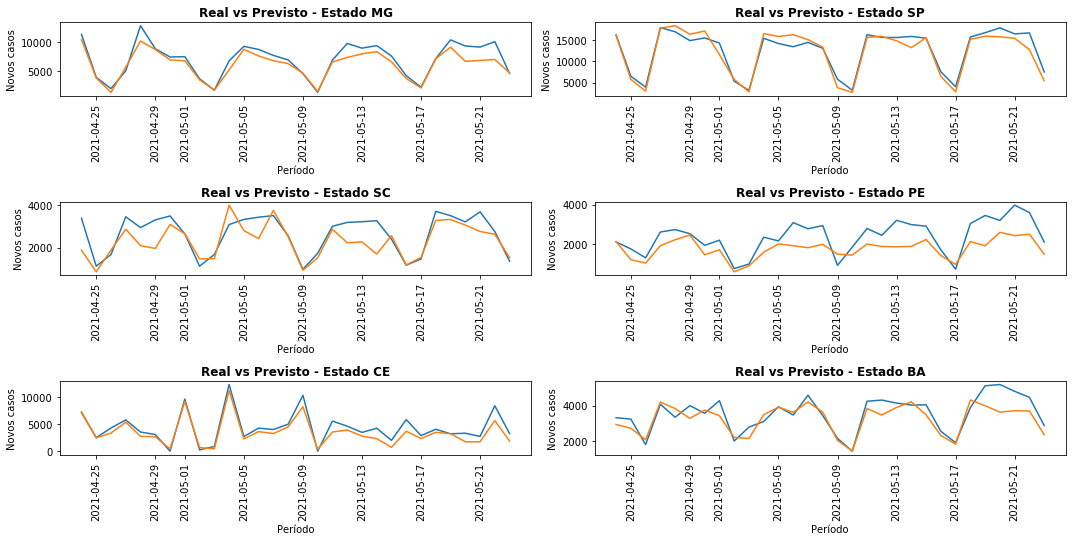

In [456]:

plt.figure(figsize=(15,14))
fixo=6
plt.subplot(fixo,2,1)
plt.plot(df_prev_MG.date,df_prev_MG.new_cases,label='Real')
plt.plot(df_prev_MG.date,df_prev_MG.y_pred.round(2),label='Previsto')
plt.xticks(rotation=90)
plt.title('Real vs Previsto - Estado MG',weight='bold')
plt.xlabel('Período')
plt.ylabel('Novos casos')

plt.subplot(fixo,2,2)
plt.plot(df_prev_SP.date,df_prev_SP.new_cases,label='Real')
plt.plot(df_prev_SP.date,df_prev_SP.y_pred.round(2),label='Previsto')
plt.xticks(rotation=90)
plt.title('Real vs Previsto - Estado SP',weight='bold')
plt.xlabel('Período')
plt.ylabel('Novos casos')

plt.subplot(fixo,2,3)
plt.plot(df_prev_SC.date,df_prev_SC.new_cases,label='Real')
plt.plot(df_prev_SC.date,df_prev_SC.y_pred.round(2),label='Previsto')
plt.xticks(rotation=90)
plt.title('Real vs Previsto - Estado SC',weight='bold')
plt.xlabel('Período')
plt.ylabel('Novos casos')

plt.subplot(fixo,2,4)
plt.plot(df_prev_PE.date,df_prev_PE.new_cases,label='Real')
plt.plot(df_prev_PE.date,df_prev_PE.y_pred.round(2),label='Previsto')
plt.xticks(rotation=90)
plt.title('Real vs Previsto - Estado PE',weight='bold')
plt.xlabel('Período')
plt.ylabel('Novos casos')

plt.subplot(fixo,2,5)
plt.plot(df_prev_CE.date,df_prev_CE.new_cases,label='Real')
plt.plot(df_prev_CE.date,df_prev_CE.y_pred.round(2),label='Previsto')
plt.xticks(rotation=90)
plt.title('Real vs Previsto - Estado CE',weight='bold')
plt.xlabel('Período')
plt.ylabel('Novos casos')

plt.subplot(fixo,2,6)
plt.plot(df_prev_BA.date,df_prev_BA.new_cases,label='Real')
plt.plot(df_prev_BA.date,df_prev_BA.y_pred.round(2),label='Previsto')
plt.xticks(rotation=90)
plt.title('Real vs Previsto - Estado BA',weight='bold')
plt.xlabel('Período')
plt.ylabel('Novos casos')

plt.tight_layout()

### Acima observa-se o gráfico de real vs previsto de uma amostra de 6 estados.